In [1]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
import torch
import numpy as np
from torch import nn
from torch import Tensor
from InformationPlane import TensorKernel, MatrixBasedRenyisEntropy, RKHSMatrixOptimizer, InformationPlane
from numpy import linalg as LA

from matplotlib import pyplot as plt



from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from tqdm import tqdm
import math

In [3]:
class TensorKernel:
    '''
        Tensor Based Radial Basis Function (RBF) Kernel

        @param x
        @param sigma
    '''
    @staticmethod
    def RBF(x: Tensor, sigma: float) -> Tensor:
        distance = torch.cdist(x, x)
        return torch.exp(-distance**2 / (sigma**2) )

class MatrixBasedRenyisEntropy():
    @staticmethod
    def entropy(A: Tensor) -> float:
        eigv = torch.symeig(A)[0].abs()
        epsilon = 1e-12
        eigv += epsilon 
        return -torch.sum(eigv*(torch.log2(eigv)))

    @staticmethod
    def jointEntropy(*args: Tensor) -> float:
        for idx, val in enumerate(args):
            if idx==0:
                A = val.clone()
            else:
                A *= val
        
        A /= A.trace()
        return MatrixBasedRenyisEntropy.entropy(A)

    @staticmethod
    def mutualInformation(Kx: Tensor, Ky: Tensor) -> float:
        entropy_Ax = MatrixBasedRenyisEntropy.entropy(Kx)
        entropy_Ay = MatrixBasedRenyisEntropy.entropy(Ky)
        joint_entropy = MatrixBasedRenyisEntropy.jointEntropy(Kx, Ky)
        return (entropy_Ax + entropy_Ay - joint_entropy)


    '''
        Generates the 'A' matrix based on RBF kernel

        @return 'A' matrix
    '''
    @staticmethod
    def tensorRBFMatrix(x: Tensor, sigma: float) -> Tensor:
        return TensorKernel.RBF(x, sigma) / len(x)


In [4]:
class RKHSMatrixOptimizer():
    def __init__(self, beta=0.5):
        if not(0 <= beta <= 1):
            raise Exception('beta must be in the range [0, 1]')

        self.beta = beta
        self.sigma = None
        self.sigma_tmp = [] #Just for saving sigma values

    # Temporal, just for testing
    def getSigmaValues(self):
        return self.sigma_tmp

    def getSigma(self):
        return self.sigma

    '''
        @param The output of a specific layer
        @param label_kernel_matrix
        @param n_sigmas
    '''
    def step(self, layer_output: Tensor, Ky: Tensor, sigma_values: list) -> float:
        sigma_t = self.optimize(layer_output, Ky, sigma_values)
        self.sigma = ( (self.beta*sigma_t) + ((1-self.beta)*self.sigma) ) if not(self.sigma is None) else sigma_t
        return self.getSigma()

    '''
        This function is used in orter to obtain the optimal kernel width for
        an T DNN layer

        @param layer_output
        @param n_sigmas: number of possible sigma values

        [Descripción del procedimiento]
    '''
    def optimize(self, x: Tensor, Ky: Tensor, sigma_values: list) -> float:
        Kt = list( map(lambda sigma: TensorKernel.RBF(x, sigma).detach(), sigma_values) )
        loss = np.array( list( map(lambda k: self.kernelAligmentLoss(k, Ky), Kt) ) )

        self.sigma_tmp.append(sigma_values[ np.argwhere(loss == loss.max()).item(0) ])
        return self.sigma_tmp[-1]

    '''
        Kernel Aligment Loss Function.

        This function is used in order to obtain the optimal sigma parameter from
        RBF kernel.  
    '''
    def kernelAligmentLoss(self, x: Tensor, y: Tensor) -> float:
        return (torch.sum(x*y)/(torch.norm(x) * torch.norm(y))).item()

In [5]:
class InformationPlane(torch.nn.Module):
    '''
        @param input_kernel: preprocessed input kernel matrix
        @param input_kernel: preprocessed label kernel matrix
        @param sigma_values: number of possible sigma values for optimizing process.
        @param step: indicates the number of step for reducing the number of possible sigma values
    '''
    def __init__(self, beta=0.5, n_sigmas=75):
        super(InformationPlane, self).__init__()

        self.sigma_optimizer = RKHSMatrixOptimizer(beta)
        self.Ixt = []
        self.Ity = []

        self.input_batch = None
        self.label_batch = None
        self.n_sigmas=n_sigmas

    def setNumberOfSigma(self, n_sigmas):
        self.n_sigmas = n_sigmas


    '''
        It's necessary to update the X and Y, input and label, in each iteration.

        @param input: batch with the original input
        @param label: label of the data
    '''
    def setInputLabel(self, inputs: Tensor, labels: Tensor):
        self.input_batch = inputs.flatten(1)
        self.label_batch = labels


    '''
        @return mutual information with label {I(X,T), I(T,Y)}
    '''
    def forward(self, x: Tensor) -> Tensor:
        if self.training:
            return x
        
        original_shape = x.shape
        x = x.flatten(1)
        
        sigma_values = self.getPossibleSigmaValues(x)
        Ky = TensorKernel.RBF(self.label_batch, 0.1)
        best_sigma = self.sigma_optimizer.step(x, Ky, sigma_values)

        A = MatrixBasedRenyisEntropy.tensorRBFMatrix(x, best_sigma).detach()
        Ay = MatrixBasedRenyisEntropy.tensorRBFMatrix(self.label_batch, 0.1).detach()
        Ax = MatrixBasedRenyisEntropy.tensorRBFMatrix(self.input_batch, 8).detach()

        self.Ixt.append(MatrixBasedRenyisEntropy.mutualInformation(Ax, A))
        self.Ity.append(MatrixBasedRenyisEntropy.mutualInformation(A, Ay))

        x = x.reshape(original_shape)
        return x

    '''
        Defines an array which contains the possible sigma values in 1-D array. The number of possible
        sigma values can be modified using the function setNumberOfSigma().

        @param x: Batch tensor
    '''
    def getPossibleSigmaValues(self, x: Tensor) -> list:
        distance = torch.cdist(x, x)
        mean_distance = distance[~torch.eye(len(distance), dtype=bool)].mean().item()
        return torch.linspace(0.1, mean_distance*10, self.n_sigmas).tolist()


    def moving_average(x: Tensor, n=10) -> Tensor :
        ret = torch.cumsum(x, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    ''' 
        @return Mutual Information {I(X,T), I(T,Y)}
    '''
    def getMutualInformation(self):
        return self.Ixt, self.Ity

In [14]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.layer1_IP = InformationPlane(beta=0.1, n_sigmas=150)
        self.layer2_IP = InformationPlane(beta=0.1, n_sigmas=150)
        self.layer3_IP = InformationPlane(beta=0.1, n_sigmas=150)
        self.layer4_IP = InformationPlane(beta=0.1, n_sigmas=150)
        self.layer5_IP = InformationPlane(beta=0.1, n_sigmas=150)

        self.layer1 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            self.layer1_IP,
        )

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 20),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(20),
            self.layer2_IP
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(20, 20),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(20),
            self.layer3_IP
        )

        self.layer4 = nn.Sequential(
            nn.Linear(20, 20),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(20),
            self.layer4_IP
        )

        self.layer5 = nn.Sequential(
            nn.Linear(20, 10)
        )


        self.softmax = torch.nn.Softmax()

    def forward(self, x: Tensor, labels=None) -> Tensor:
        if not(self.training):
            [ip.setInputLabel(x, labels) for ip in self.getInformationPlaneLayers()]

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        self.layer5_IP(self.softmax(x))

        return x

    def getInformationPlaneLayers(self):
        return [self.layer1_IP, self.layer2_IP, self.layer3_IP, self.layer4_IP, self.layer5_IP]

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1_IP = InformationPlane(beta=0.1, n_sigmas=150)
        self.layer2_IP = InformationPlane(beta=0.1, n_sigmas=150)
        self.layer3_IP = InformationPlane(beta=0.1, n_sigmas=150 )
        self.layer4_IP = InformationPlane(beta=0.1, n_sigmas=150 )
        self.fc_IP = InformationPlane(beta=0.1, n_sigmas=150)


        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            self.layer1_IP,
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            self.layer2_IP,
            nn.MaxPool2d(2, stride=2, ceil_mode=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            self.layer3_IP,
            nn.MaxPool2d(2, stride=2, ceil_mode=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(400, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            self.layer4_IP,
            nn.Linear(256, 10)
        )

        
        self.softmax = torch.nn.Softmax()

    def forward(self, x: Tensor, labels=None) -> Tensor:
        if not(self.training):
            [ip.setInputLabel(x, labels) for ip in self.getInformationPlaneLayers()]
        

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        self.fc_IP(self.softmax(x))
        return x

    def getInformationPlaneLayers(self):
        return [self.layer1_IP, self.layer2_IP, self.layer3_IP, self.layer4_IP, self.fc_IP]

In [38]:
# net = MLP().cuda()
net = CNN().cuda()

In [39]:
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from tqdm import tqdm
import math
from torch.nn.functional import one_hot


# transformToTensor = Compose([ ToTensor(), Normalize((0.1307,), (0.3081,))])
transformToTensor = Compose([ ToTensor()])
dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
train_set, val_set = torch.utils.data.random_split(dataset, [45000, 15000])
dataloader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=0)
dataloader_2 = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=0)


# val_inputs = torch.load("tests/eval_inputs_0.pt").flatten(1).cuda()
# val_labels = torch.load("tests/eval_labels_0.pt").cuda()

val_inputs, val_labels = next(iter(dataloader_2))
# val_inputs = val_inputs.flatten(1).cuda()
val_inputs = val_inputs.cuda()
val_labels = val_labels.cuda()
val_labels = one_hot(val_labels, num_classes=10).float()

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

loss_record = []

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0

    with torch.no_grad():
        net.eval()
        net(val_inputs, val_labels)
        
    for inputs, labels in tqdm(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        # inputs = inputs.flatten(1).cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()

        net.train()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = net(inputs, one_hot(labels, num_classes=10).float())
        outputs = net(inputs)

        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()
        if (i+1) % 50 == 0:    # print every 25 mini-batches
            loss_record.append(running_loss / 25)
            # print('[%d, %5d] loss: %.3f' %
            #     (epoch + 1, i + 1, running_loss / 25))
            running_loss = 0.0

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            net.eval()
            net(val_inputs, val_labels)

        if i > 200:
            for ip in net.getInformationPlaneLayers():
                ip.setNumberOfSigma(50)

        i += 1

print('Finished Training')

100%|██████████| 450/450 [01:52<00:00,  4.00it/s]Finished Training



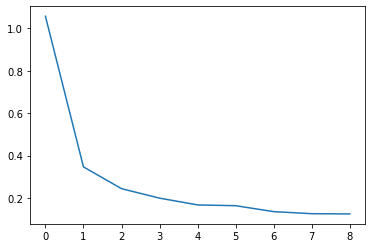

In [40]:
plt.plot(loss_record)
plt.show()

In [41]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

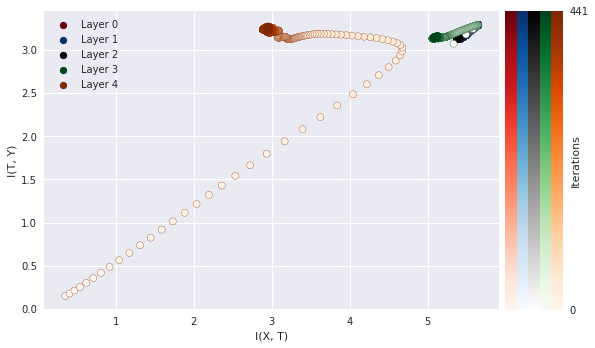

In [42]:
with plt.style.context('seaborn'):
    ips = net.getInformationPlaneLayers()
    colors = ['Reds', 'Blues', 'binary', 'Greens', 'Oranges']

    fig = plt.figure(constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.84, wspace=0.05)
    gs2 = fig.add_gridspec(nrows=1, ncols=5, left=0.85, right=0.95, wspace=0)
    f8_ax1 = fig.add_subplot(gs1[:, :])
    f8_ax1.set_xlabel("I(X, T)")
    f8_ax1.set_ylabel("I(T, Y)")

    for idx, ip in enumerate(ips):
        cmap = plt.cm.get_cmap(colors[idx])
        Ixt, Ity = ip.getMutualInformation()
        Ixt = moving_average(Ixt, n=10)
        Ity = moving_average(Ity, n=10)
        iterations = np.arange(len(Ixt))
        color = np.array([cmap(iterations[-1])])
        sc = f8_ax1.scatter(Ixt, Ity, c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
        f8_ax1.scatter([], [], c=color, label="Layer {}".format(idx))

        f8_ax2 = fig.add_subplot(gs2[0, idx])
        cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
        cb.set_ticks([])
        
        # if idx > 2:
        #     break

    f8_ax1.legend()
    cb.set_ticks([0, iterations.max()])
    cb.set_label("Iterations", labelpad=-18)

    plt.show()

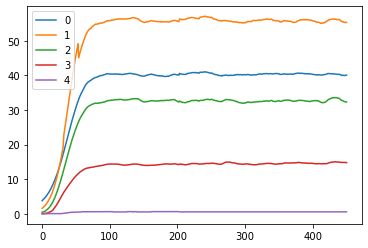

In [43]:
from matplotlib import pyplot as plt

ips = net.getInformationPlaneLayers()
for i, ip in enumerate(ips):
    plt.plot(ip.sigma_optimizer.getSigmaValues(), label=i)

plt.legend()
plt.show()


# Testing new Information Plane

In [16]:
inputs = torch.load("tests/eval_inputs_2.pt").flatten(1)
labels = torch.load("tests/eval_labels_2.pt")
x_1 = net.layer1(inputs.cuda())
x_2 = net.layer2(x_1)
x_3 = net.layer3(x_2)
pre_output = net.layer4(x_3)
output = net.layer5(pre_output)
softmax = torch.nn.Softmax()
softmax_output = softmax(output)

In [99]:
softmax = torch.nn.Softmax()
softmax_output = softmax(output)
n_sigmas = 75
distance = torch.cdist(x_1[:], x_1[:])
# distance /= distance.max()
mean_distance = distance[~torch.eye(len(distance), dtype=bool)].mean().item()
start = (mean_distance*0.1)
end = (mean_distance*10)

possible_sigma_values = torch.linspace(start, end, n_sigmas).tolist()
print(possible_sigma_values)

[6.274118900299072, 14.667871475219727, 23.06162452697754, 31.45537757873535, 39.8491325378418, 48.24288558959961, 56.63663864135742, 65.03038787841797, 73.42414093017578, 81.8178939819336, 90.2116470336914, 98.60540008544922, 106.99915313720703, 115.39290618896484, 123.78665924072266, 132.180419921875, 140.5741729736328, 148.96792602539062, 157.36167907714844, 165.75543212890625, 174.14918518066406, 182.54293823242188, 190.9366912841797, 199.3304443359375, 207.7241973876953, 216.11795043945312, 224.51170349121094, 232.90545654296875, 241.29920959472656, 249.69296264648438, 258.0867004394531, 266.48046875, 274.87420654296875, 283.2679443359375, 291.6617126464844, 300.05548095703125, 308.44921875, 316.84295654296875, 325.2367248535156, 333.6304931640625, 342.02423095703125, 350.41796875, 358.8117370605469, 367.20550537109375, 375.5992431640625, 383.99298095703125, 392.3867492675781, 400.780517578125, 409.17425537109375, 417.5679931640625, 425.9617614746094, 434.35552978515625, 442.74926

In [101]:
softmax = torch.nn.Softmax()
softmax_output = softmax(output)
n_sigmas = 75
distance = torch.cdist(x_1[:25], x_1[:25])
# distance /= distance.max()
mean_distance = distance[~torch.eye(len(distance), dtype=bool)].mean().item()
start = (mean_distance*0.1)
end = (mean_distance*10)

possible_sigma_values = torch.linspace(start, end, n_sigmas).tolist()
print(possible_sigma_values)

[6.273530006408691, 14.666495323181152, 23.059459686279297, 31.45242691040039, 39.84539031982422, 48.23835754394531, 56.63132095336914, 65.02428436279297, 73.41725158691406, 81.81021881103516, 90.20318603515625, 98.59614562988281, 106.9891128540039, 115.382080078125, 123.77503967285156, 132.1680145263672, 140.56097412109375, 148.9539337158203, 157.34690856933594, 165.7398681640625, 174.13284301757812, 182.5258026123047, 190.91876220703125, 199.31173706054688, 207.70469665527344, 216.09765625, 224.49063110351562, 232.8835906982422, 241.27655029296875, 249.66952514648438, 258.0625, 266.4554443359375, 274.8484191894531, 283.24139404296875, 291.63433837890625, 300.0273132324219, 308.4202880859375, 316.813232421875, 325.2062072753906, 333.59918212890625, 341.9921569824219, 350.3851013183594, 358.778076171875, 367.1710510253906, 375.5639953613281, 383.95697021484375, 392.3499450683594, 400.7428894042969, 409.1358642578125, 417.5288391113281, 425.9217834472656, 434.31475830078125, 442.7077331

In [95]:
def kernel_loss(k_x, k_y, k_l):
        beta = 1.0
        L = torch.norm(k_l)
        Y = torch.norm(k_y) ** beta
        X = torch.norm(k_x) ** (1-beta)
        LY = torch.trace(torch.matmul(k_l, k_y))**beta
        LX = torch.trace(torch.matmul(k_l, k_x))**(1-beta)
        return 2*torch.log2((LY*LX)/(L*Y*X))

def kernelAligmentLoss(x, y) -> float:
        return (torch.sum(x*y)/(torch.norm(x) * torch.norm(y))).item()

In [17]:
Kx = TensorKernel.RBF(inputs[0:75], 8) / 75
Ky = TensorKernel.RBF(labels[0:75], 0.1) / 75
Kt_1 = TensorKernel.RBF(x_1[0:75], 15) / 75
Kt_2 = TensorKernel.RBF(x_2[0:75], 1.5) / 75
Kt = TensorKernel.RBF(softmax_output[0:75], 0.1) / 75

print(torch.matrix_rank(Kx))
print(torch.matrix_rank(Ky))
print(torch.matrix_rank(Kt_1))
print(torch.matrix_rank(Kt_2))
print(torch.matrix_rank(Kt))

entropy_kx = MatrixBasedRenyisEntropy.entropy(Kx.cuda())
entropy_ky = MatrixBasedRenyisEntropy.entropy(Ky.cuda())
entropy_kt = MatrixBasedRenyisEntropy.entropy(Kt.cuda())
entropy_kt_1 = MatrixBasedRenyisEntropy.entropy(Kt_1.cuda())
entropy_kt_2 = MatrixBasedRenyisEntropy.entropy(Kt_2.cuda())
joint_entropy_kxkt = MatrixBasedRenyisEntropy.jointEntropy(Kx.cuda(), Kt.cuda())
joint_entropy_kxkt_1 = MatrixBasedRenyisEntropy.jointEntropy(Kx.cuda(), Kt_1.cuda())
joint_entropy_kxkt_2 = MatrixBasedRenyisEntropy.jointEntropy(Kx.cuda(), Kt_2.cuda())
joint_entropy_ktky = MatrixBasedRenyisEntropy.jointEntropy(Kt.cuda(), Ky.cuda())
joint_entropy_kt_1ky = MatrixBasedRenyisEntropy.jointEntropy(Kt_1.cuda(), Ky.cuda())
joint_entropy_kt_2ky = MatrixBasedRenyisEntropy.jointEntropy(Kt_2.cuda(), Ky.cuda())

# print(entropy_kx)
# print(entropy_ky)
# print(entropy_kt)
# print(joint_entropy_kxkt)
# print(joint_entropy_ktky)

print("Mutual Information Kt_1")
print(entropy_kx + entropy_kt_1 - joint_entropy_kxkt_1)
print(entropy_kt_1 + entropy_ky - joint_entropy_kt_1ky)

print("Mutual Information Kt_2")
print(entropy_kx + entropy_kt_2 - joint_entropy_kxkt_2)
print(entropy_kt_2 + entropy_ky - joint_entropy_kt_2ky)

print("Mutual Information Kt")
print(entropy_kx + entropy_kt - joint_entropy_kxkt)
print(entropy_kt + entropy_ky - joint_entropy_ktky)


tensor(75)
tensor(65)
tensor(75, device='cuda:0')
tensor(75, device='cuda:0')
tensor(51, device='cuda:0')
Mutual Information Kt_1
tensor(5.2453, device='cuda:0', grad_fn=<SubBackward0>)
tensor(3.2848, device='cuda:0', grad_fn=<SubBackward0>)
Mutual Information Kt_2
tensor(5.2309, device='cuda:0', grad_fn=<SubBackward0>)
tensor(3.2846, device='cuda:0', grad_fn=<SubBackward0>)
Mutual Information Kt
tensor(3.5036, device='cuda:0', grad_fn=<SubBackward0>)
tensor(3.2224, device='cuda:0', grad_fn=<SubBackward0>)


In [57]:
length = 30
Kx = TensorKernel.RBF(inputs[0:length], 8) / length
Ky = TensorKernel.RBF(labels[0:length], 0.1) / length
Kt_1 = TensorKernel.RBF(x_1[0:length], 15.8) / length
Kt = TensorKernel.RBF(softmax_output[0:length], 0.6) / length

print("A")
entropy_kx = MatrixBasedRenyisEntropy.entropy(Kx.cuda())
print("B")
entropy_ky = MatrixBasedRenyisEntropy.entropy(Ky.cuda())
print("C")
entropy_kt = MatrixBasedRenyisEntropy.entropy(Kt.cuda())
print("D")
entropy_kt_1 = MatrixBasedRenyisEntropy.entropy(Kt_1.cuda())
joint_entropy_kxkt = MatrixBasedRenyisEntropy.jointEntropy(Kx.cuda(), Kt.cuda())
joint_entropy_kxkt_1 = MatrixBasedRenyisEntropy.jointEntropy(Kx.cuda(), Kt_1.cuda())
joint_entropy_ktky = MatrixBasedRenyisEntropy.jointEntropy(Kt.cuda(), Ky.cuda())
joint_entropy_kt_1ky = MatrixBasedRenyisEntropy.jointEntropy(Kt_1.cuda(), Ky.cuda())

# print(entropy_kx)
# print(entropy_ky)
# print(entropy_kt)
# print(joint_entropy_kxkt)
# print(joint_entropy_ktky)

print("Mutual Information Kt_1")
print(entropy_kx + entropy_kt_1 - joint_entropy_kxkt_1)
print(entropy_kt_1 + entropy_ky - joint_entropy_kt_1ky)

print("Mutual Information Kt")
print(entropy_kx + entropy_kt - joint_entropy_kxkt)
print(entropy_kt + entropy_ky - joint_entropy_ktky)

A
B
C
D
Mutual Information Kt_1
tensor(4.3471, device='cuda:0', grad_fn=<SubBackward0>)
tensor(3.1829, device='cuda:0', grad_fn=<SubBackward0>)
Mutual Information Kt
tensor(3.0835, device='cuda:0', grad_fn=<SubBackward0>)
tensor(3.0981, device='cuda:0', grad_fn=<SubBackward0>)


In [92]:
softmax = torch.nn.Softmax()
softmax_output = softmax(output)
with torch.no_grad():
    Ky = TensorKernel.RBF(labels[0:30], 0.1).cuda()
    Kx = TensorKernel.RBF(inputs[0:30], 8).cuda()
    Kts = list( map(lambda sigma: TensorKernel.RBF(softmax_output[0:30], sigma).cuda(), possible_sigma_values) )
    loss = np.array( list( map(lambda k: kernelAligmentLoss(k, Ky), Kts) ) )
    # loss = np.array( list( map(lambda k: kernel_loss(Kx, Ky, k), Kts) ) )
    best_sigma = possible_sigma_values[ (np.argwhere(loss == loss.max())).item() ]
    # print(loss)
    # print(possible_sigma_values)
    print(best_sigma)
    # self.sigma_tmp.append(sigma_values[ np.argwhere(loss == loss.max()).item(0) ])

    # Ay = MatrixBasedRenyisEntropy.tensorRBFMatrix(labels[0:30], 0.1)
    # Ax = MatrixBasedRenyisEntropy.tensorRBFMatrix(inputs[0:30], 8)
    # A = MatrixBasedRenyisEntropy.tensorRBFMatrix(softmax_output[0:30], best_sigma)
    
    Ay = TensorKernel.RBF(labels[0:30], 0.1) / 30
    Ax = TensorKernel.RBF(inputs[0:30], 8) / 30
    A = TensorKernel.RBF(softmax_output[0:30], best_sigma) / 30

    print(Ay.shape)
    print(torch.matrix_rank(Ay))
    print(Ax.shape)
    print(torch.matrix_rank(Ax))
    print(A.shape)
    print(torch.matrix_rank(A))

    print(MatrixBasedRenyisEntropy.mutualInformation(Ax.cuda(), A.cuda()))
    print(MatrixBasedRenyisEntropy.mutualInformation(A.cuda(), Ay.cuda()))

0.1240960955619812
torch.Size([30, 30])
tensor(30)
torch.Size([30, 30])
tensor(30)
torch.Size([30, 30])
tensor(28, device='cuda:0')
tensor(3.1974, device='cuda:0')
tensor(3.1661, device='cuda:0')


In [47]:
def dist_mat(x, y=None):
    try:
        x = torch.from_numpy(x)
    except TypeError:
        x = x

    dist = torch.norm(x[:, None] - x, dim=2, p=2)
    return dist / dist.max()

In [ ]:
distance_1 = dist_mat(pre_output)
distance_2 = torch.cdist(pre_output, pre_output)
print(torch.allclose(distance_1, distance_2/distance_2.max()))

In [ ]:
distance = torch.cdist(pre_output, pre_output, compute_mode='use_mm_for_euclid_dist') 
distance = distance / distance.max()
print(distance[:2])
print(distance_1[:2])

In [ ]:
k = dist_mat(softmax_output)
print(k.shape)
print(torch.sort(k)[0][:, :50].shape)
sigma = torch.sort(k)[0][:, :50].mean()
print(sigma)

In [64]:
def dist_mat(x):
    dist = torch.norm(x[:, None] - x, dim=2)
    return dist

a = torch.rand(150, 750)
distance_1 = torch.cdist(a, a)
distance_1 = distance_1[~torch.eye(len(distance_1), dtype=bool)].mean().item()
distance_2 = dist_mat(a)

print(distance_1.mean())

print(distance_2.mean())

11.18381118774414
tensor(11.1093)
